In [18]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import numpy as np
import cv2 as cv
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split as split_data
import time

## **Xây dựng mô hình**

In [19]:
def ClassifySignModel():
    model = Sequential()
    width = 32
    height = 32
    classes = 4
    shape = (width, height, 3)
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    learning_rate = 0.01
    opt = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return  model

## **Huấn luyện**

###  Chuẩn bị dữ liệu






In [36]:
%cd /content/drive/My Drive/ClassifySign-DL/ClassifySign
data_path = '/content/drive/My Drive/ClassifySign-DL/ClassifySign/Data32x32'
def create_data():
    data= []
    for directory in ['Fast', 'Slow','Start','Stop']:
        image_path = os.path.join(data_path, directory)
        if directory == 'Fast':
            label = 0
        elif directory == 'Slow':
            label = 1
        elif directory == 'Start':
            label = 2
        elif directory == 'Stop':
            label =3
        for img in tqdm(os.listdir(image_path)):
            path = os.path.join(image_path, img)
            img_data=cv.imread(path)
            data.append([np.array(img_data), label])
    shuffle(data)
    np.save('data.npy', data)
    return data

/content/drive/My Drive/ClassifySign-DL/ClassifySign


### Tiến hành training

In [38]:
 def training(model):
    model.summary()
    aug = ImageDataGenerator(rotation_range=0.18, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

    dataX= create_data()

    # Chia tập dữ liệu thành 2 phần
    train, test = split_data(dataX, test_size=0.2, random_state=42)
    image_train = np.array([i[0] for i in train])
    label_train = [i[1] for i in train]
    image_test = np.array([i[0] for i in test])
    label_test = [i[1] for i in test]

    lb = LabelBinarizer()
    label_train = lb.fit_transform(label_train)
    label_test = lb.fit_transform(label_test)
    image_train = image_train.astype("float") / 255.0
    image_test = image_test.astype("float") / 255.0
    #print(dataX)

    epochs = 10
    batch_size = 16
    print("Start training")

    checkpoint_path = "training/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1, period=5)
    # This may generate warnings related to saving the state of the optimizer.
    # These warnings (and similar warnings throughout this notebook)
    # are in place to discourage outdated usage, and can be ignored.

    model.fit(image_train, label_train, epochs=10, validation_data =(image_test, label_test),batch_size=16, steps_per_epoch=image_train.shape[0]/batch_size)
    #model.fit_generator(aug.flow(image_train, label_train, batch_size=batch_size), validation_data=(image_test, label_test), steps_per_epoch=x_train.shape[0]/batch_size, epochs=epochs, verbose=1, callbacks=[cp_callback])
    model.save_weights("classifySign.h5")

### Thực hành nhận dạng vật thể

In [81]:
def classify(image, boxe): # boxe = (x, y, xmax, ymax)
    # # Create a basic model instance
    # model = ClassifySignModel()

    # checkpoint_path = "training/cp.ckpt"
    # checkpoint_dir = os.path.dirname(checkpoint_path)
    # # Loads the weights
    # model.load_weights(checkpoint_path)

    # Recreate the exact same model, including its weights and the optimizer
    new_model = ClassifySignModel()
    new_model.load_weights('classifySign.h5')

    # Show the model architecture
    new_model.summary()

    def crop(img, coords):
        x_max = coords[2]
        x_min = coords[0]
        y_max = coords[3]
        y_min = coords[1]
        crop_img = img[y_min:y_max, x_min:x_max]
        return crop_img
    def check_boxe():
        if boxe[2] - boxe [0] <= 32:
          print('Check False')
          return False
        if boxe[3] - boxe [1] <= 32:
          print('Check False')
          return False
        print('Check True')
        return True
    classes = ["Fast", "Slow", "Start", "Stop"]
    result = None
    if check_boxe():
        image = crop(image, boxe)
        image=cv.resize(image,(32,32))
        
        cv2_imshow(image)
        image = np.array(image)
        image = image.astype("float")/255.0

        test = np.expand_dims(image, axis=0)
        strt = time.time()
        result = new_model.predict(test)  #---- OK, chua Ok do ham reshape
        stp = time.time()
        print(stp -strt)
    return result, classes
    


In [78]:
from google.colab.patches import cv2_imshow

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_324 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_270 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_325 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_271 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 16, 16, 32)      

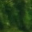

0.1997816562652588


(array([[1.7140029e-03, 3.6418514e-05, 9.9824959e-01, 1.3085151e-08]],
       dtype=float32), ['Fast', 'Slow', 'Start', 'Stop'])

In [83]:
model = ClassifySignModel()

ima = cv.imread('/content/drive/My Drive/ClassifySign-DL/ClassifySign/0a.jpg')
classify(ima, (32,60, 72, 120))